In [1]:
# Sentiment Analysis

# After doing some research, we will want to use TensorFlow, prob Keras (a deep
# learning API written on top of TensorFlow, it's currently being used
# in the LHC (Large Hadron Collider)).

# We will be classifying text with BERT:
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert

# NOTE: as of 10/19/23 tensorflow will not run on windowns
# I recomend running this through jupyterlab on a linux kernal


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
Requirement already up-to-date: tensorflow-text==2.13.* in /home/owenkutzscher/.local/lib/python3.8/site-packages (2.13.0)


In [3]:
# Use use the AdamW optimizer from https://github.com/tensorflow/models.
!pip install "tf-models-official==2.13.*"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
# import nesisary libraries

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text 
from official.nlp import optimization  # to create AdamW optimizer

import keras
import keras.utils
import keras.layers
import keras.models
import keras.optimizers
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-12-03 18:04:34.306804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 18:04:35.172882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 18:04:35.180764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 18:04:37.797244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Set up dataset directory structure
# This will make it easy to organize and accesss our data in our directory structure


dataset_dir = '../data/amazon_reviews'
os.makedirs(dataset_dir, exist_ok=True)

# Make it easy to access 'train' and 'test' directories inside the dataset directory
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# This will build the 'train' and 'test' directories if they haven't been built yet
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# This will build the folders 1, 2, 3, 4, 5 inside both the train and test directories
one_dir_train = os.path.join(train_dir, '1')
two_dir_train = os.path.join(train_dir, '2')
three_dir_train = os.path.join(train_dir, '3')
four_dir_train = os.path.join(train_dir, '4')
five_dir_train = os.path.join(train_dir, '5')
os.makedirs(one_dir_train, exist_ok=True)
os.makedirs(two_dir_train, exist_ok=True)
os.makedirs(three_dir_train, exist_ok=True)
os.makedirs(four_dir_train, exist_ok=True)
os.makedirs(five_dir_train, exist_ok=True)
one_dir_test = os.path.join(test_dir, '1')
two_dir_test = os.path.join(test_dir, '2')
three_dir_test = os.path.join(test_dir, '3')
four_dir_test = os.path.join(test_dir, '4')
five_dir_test = os.path.join(test_dir, '5')
os.makedirs(one_dir_test, exist_ok=True)
os.makedirs(two_dir_test, exist_ok=True)
os.makedirs(three_dir_test, exist_ok=True)
os.makedirs(four_dir_test, exist_ok=True)
os.makedirs(five_dir_test, exist_ok=True)

In [6]:
# Downloading the dataset
# IMPORTANT!!!!
# In order to run this project drop in the .csv data set (called: "Reviews") into the "data" folder
# You can find the data set here:
# https://www.google.com/url?q=https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews&sa=D&source=docs&ust=1695764896933142&usg=AOvVaw1WeATDdUdlTItgNGGldkRF

import pandas as pd

# Read the CSV file
df_extra_params = pd.read_csv("../data/Reviews.csv")

# Select only the "Score" and "Text" columns
df_unbalanced = df_extra_params[["Score", "Text"]]

# Determine minimum number of reviews for any score
min_reviews = df_unbalanced['Score'].value_counts().min()

# Make sure each review score 1-5 has the same number of reviews
df = df_unbalanced.groupby('Score').apply(lambda x: x.sample(min_reviews)).reset_index(drop=True)

# Display the resulting DataFrame
df.head()

,Score,Text
0,1,Do not bother. They are only good for 4 months...
1,1,I bought this coffee because the cost is about...
2,1,Come on AMZN - or someone - straighten out the...
3,1,"This review will make me sound really stupid, ..."
4,1,Apparently this deal for people who are really...


In [7]:
# Copying the data into our directory structure
# We will seperate the data into the train and test folders
# Inside the train and test folders we have folders 1, 2, 3, 4, 5
# This corresponds to the "Score" of the review
# Split with 50/50 ratio, randomly divided 
# Also take note of the "sample_fraction" variable, this is used to
# reduce the ammount of data we will feed to BERT. This will help us
# reduce training time when expiramenting with BERT.


import shutil
import random

# Path to the base folder
base_folder = '../data/amazon_reviews'

# Delete existing reviews from train and test folders
for score_folder in ['1', '2', '3', '4', '5']:
    train_folder_path = f'{base_folder}/train/{score_folder}'
    test_folder_path = f'{base_folder}/test/{score_folder}'

    shutil.rmtree(train_folder_path, ignore_errors=True)
    shutil.rmtree(test_folder_path, ignore_errors=True)

    # Recreate the train and test folders
    os.makedirs(train_folder_path)
    os.makedirs(test_folder_path)



# Determine the fraction for sampling (1/40th of the entire dataset)
# Tip: for extra speedy runtimes, make this 1/40
sample_fraction = 1/20

# Separate all data into 5 dfs for scores 1-5 respectively
df_1 = df.loc[(df["Score"] == 1)]
df_2 = df.loc[(df["Score"] == 2)]
df_3 = df.loc[(df["Score"] == 3)]
df_4 = df.loc[(df["Score"] == 4)]
df_5 = df.loc[(df["Score"] == 5)]

# Splitting data into test and train folders with a 50/50 ratio
df_1_train = df_1.sample(frac=sample_fraction, replace=False, random_state=1)
df_1_test = df_1[~df_1.isin(df_1_train)].dropna(how='all')

df_2_train = df_2.sample(frac=sample_fraction, replace=False, random_state=1)
df_2_test = df_2[~df_2.isin(df_2_train)].dropna(how='all')

df_3_train = df_3.sample(frac=sample_fraction, replace=False, random_state=1)
df_3_test = df_3[~df_3.isin(df_3_train)].dropna(how='all')

df_4_train = df_4.sample(frac=sample_fraction, replace=False, random_state=1)
df_4_test = df_4[~df_4.isin(df_4_train)].dropna(how='all')

df_5_train = df_5.sample(frac=sample_fraction, replace=False, random_state=1)
df_5_test = df_5[~df_5.isin(df_5_train)].dropna(how='all')

# Converting df values into txt files, putting them in the correct folders
def save_reviews_to_folder(df, folder_path, score):
    for index, row in df.iterrows():
        path = f'{folder_path}/review{index}.txt'
        with open(path, 'a') as f:
            txt_in = row["Text"]
            f.write(txt_in)

# Define folder paths
train_folder_base = '../data/amazon_reviews/train'
test_folder_base = '../data/amazon_reviews/test'

# Save reviews to train and test folders
save_reviews_to_folder(df_1_train, f'{train_folder_base}/1', 1)
save_reviews_to_folder(df_1_test, f'{test_folder_base}/1', 1)

save_reviews_to_folder(df_2_train, f'{train_folder_base}/2', 2)
save_reviews_to_folder(df_2_test, f'{test_folder_base}/2', 2)

save_reviews_to_folder(df_3_train, f'{train_folder_base}/3', 3)
save_reviews_to_folder(df_3_test, f'{test_folder_base}/3', 3)

save_reviews_to_folder(df_4_train, f'{train_folder_base}/4', 4)
save_reviews_to_folder(df_4_test, f'{test_folder_base}/4', 4)

save_reviews_to_folder(df_5_train, f'{train_folder_base}/5', 5)
save_reviews_to_folder(df_5_test, f'{test_folder_base}/5', 5)

In [8]:
# Lets do a quick sanity check to make sure our reviews are 
# evenly distributed in our directory

import os

folder_path = '../data/amazon_reviews/train/4'

# Get the list of items in the folder
items = os.listdir(folder_path)

# Print the number of items in the folder
print(len(items))


# repeat but with a different reviews folder
folder_path = '../data/amazon_reviews/train/3'

items = os.listdir(folder_path)

print(len(items))

1488
1488


In [9]:
# Now we will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.
# Let's create a validation set using an 80:20 split of the training data by
# using the validation_split argument below.

# Note: When using the validation_split and subset arguments
# make sure to either specify a random seed, or to pass shuffle=False, 
# so that the validation and training splits have no overlap.


AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '../data/amazon_reviews/train',
    batch_size=batch_size,
    validation_split=0.2,
    labels='inferred',
    subset='training',
    seed=seed,
    label_mode='int')

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '../data/amazon_reviews/train',
    batch_size=batch_size,
    validation_split=0.2,
    labels='inferred',
    subset='validation',
    seed=seed,
    label_mode='int')

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '../data/amazon_reviews/test',
    batch_size=batch_size,
    labels='inferred',
    label_mode='int')

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 7440 files belonging to 5 classes.
Using 5952 files for training.


2023-12-03 18:05:22.098842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 18:05:22.134061: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 7440 files belonging to 5 classes.
Using 1488 files for validation.
Found 141405 files belonging to 5 classes.


In [10]:
train_ds.element_spec[1]

TensorSpec(shape=(None,), dtype=tf.int32, name=None)

In [11]:
# Tentative function for one hot encoding NOT RELIABLE 
def _map_func(text, labels):
    # i=0
    # labels_enc = tf.TensorArray(tf.float32, size=0, dynamic_size=True,clear_after_read=False)
    # for text_batch, label_batch in train_ds.take(1):
    #     label = label_batch.numpy()[i]
    #     if label==0:
    #         label = 1
    #     elif label==1:
    #         label = 2
    #     elif label==2:
    #         label = 3
    #     elif label==3:
    #         label = 4
    #     else: 
    #         label = 5
    #     print(f'Label : {label} ({class_names[label]})')
    # for label in labels:
    #     if label.numpy()[i]==0:
    #         label.numpy()[i] = 1
    #     elif label.numpy()[i]==1:
    #         label.numpy()[i] = 2
    #     elif label.numpy()[i]==2:
    #         label.numpy()[i] = 3
    #     elif label.numpy()[i]==3:
    #         label.numpy()[i] = 4
    #     else: 
    #         label.numpy()[i] = 5
        # label = tf.one_hot(label, 5, name='label', axis=-1)
        # labels_enc.write(i, label)
        # i+=1

#     return text, labels
    pass
# train_ds = train_ds.map(_map_func)
# test_ds = test_ds.map(_map_func)
# val_ds = val_ds.map(_map_func)


In [12]:
train_ds = train_ds

In [13]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"While I have liked the other products in this line, using this was a disaster. My scalp has been itchy, with signs of dandruff, and I thought since the other products were so helpful this would be good as well. Yikes.<br /><br />For starters, there are no directions on the jar so what to do? It's very greasy but I took a handful and rubbed it into my scalp and massaged. So far, so good. I left it on my scalp for the rest of the evening, to give it a chance to work. The horror started when I tried to wash it out. After shampooing it three times, I gave up and just let it dry. The next morning I was a mass of greasy-looking curls. I'll be washing my hair every day until I get rid of this, but I certainly won't try it again."
Label : 0 (1)
Review: b'Good Earl Grey Tea but nothing about it was special. The "double bergamot" went unoticed.'
Label : 2 (3)
Review: b'Great taste with no saturated or trans fat.  A little high priced though, but well worth it for controlling cholestero

2023-12-03 18:05:43.767871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
for row in train_ds.take(1):
    print(row)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'I wanted to really like this cereal.  We are big into old fashioned oatmeal for breakfast, as well as cooking with oats, in cookies and breads.  A ready-to-serve oat cereal, with enough actual oats in it to count, would be nice.  Unfortunately, we are underwhelmed by this product.  It has an unappetizing rather gray color.  The texture is a bit "off".  And the taste is bland... VERY bland.  The cinnamon is almost unrecognizable.  For the amount of sugar in it, it\'s not very sweet tasting.  In general, we don\'t really care for it much.  Sounds good, but we\'ll stick to oatmeal....',
       b'This was the first kind my family and I bought.  Lucky for me I didn\'t let it stop me from trying the golden flax flavor.  OMG - I eat it for breakfast, lunch, snack - it\'s the best way to "cheat" when you get those after hour urges.  It\'s sprouted grains and very nutritious with a good amount of protein.  I have it after my superfood/frui

2023-12-03 18:05:43.825446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
# Looking at what labels correspond to what ratings
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to 1
Label 1 corresponds to 2


In [16]:
# Now we will load up a model with TensorFlow Hub
# We will be using a small BERT to start with
# to read about all the BERT model available click this link
# https://colab.research.google.com/drive/1UytfDnUpCQTHK8BA8n__B4YCWm4gzIeW#scrollTo=dX8FtlpGJRE6



#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models.

The preprocessing model must be the one referenced by the documentation of the BERT model.

Note: We will load the preprocessing model into a hub.KerasLayer to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [17]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [18]:
text_test = ['this is such an amazing product!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 4031  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask and input_type_ids).

Some other important points:

The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the Solve GLUE tasks using BERT on a TPU colab.
The input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

## Using the BERT model

Before putting BERT into our model, let's take a look at its outputs. We will load it from TF Hub and see the returned values.

In [19]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

2023-12-03 18:05:49.362924: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62509056 exceeds 10% of free system memory.


In [20]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.25607762  0.99775714 -0.44676334  0.26639184  0.21934545  0.4369908
  0.9671976  -0.9815667  -0.12048458 -0.9863795   0.09855987 -0.9820184 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.3783573   0.7921103   0.1786601  ... -0.02951667  0.538883
  -0.10518394]
 [-0.22593099  0.5280534  -0.01349462 ...  0.79969656 -0.22486237
   0.91444945]
 [-0.72409266  1.1752067  -0.8487483  ...  0.13510157 -0.39533997
   0.7117271 ]
 ...
 [-0.05767777  0.0561218  -0.1703752  ...  0.46868443  0.7525872
   0.51038325]
 [-0.1021568   0.14873698 -0.13012728 ...  0.43205714  1.0691454
   0.2722145 ]
 [-0.39473408  0.60435665 -0.13972668 ... -0.07493064  1.1170473
   0.2523077 ]]


The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

pooled_output represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.
encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.
For the fine-tuning you are going to use the pooled_output array.

Define your model
You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net =  tf.keras.layers.Dense(15, activation = 'relu')(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [22]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

2023-12-03 18:05:57.024328: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62509056 exceeds 10% of free system memory.


tf.Tensor([[0.51439446 0.6772151  0.531928   0.5114952  0.5068818 ]], shape=(1, 5), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

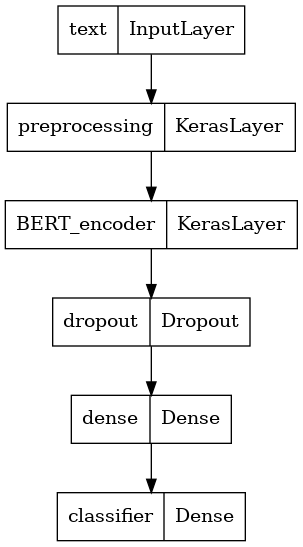

In [23]:
tf.keras.utils.plot_model(classifier_model)


## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function



In [24]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

### Optimizer
For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [25]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training
Using the classifier_model you created earlier, you can compile the model with the loss, metric and optimizer.

In [26]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [27]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/3


2023-12-03 18:06:02.390489: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62509056 exceeds 10% of free system memory.
2023-12-03 18:06:02.653054: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62509056 exceeds 10% of free system memory.
2023-12-03 18:06:07.430941: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62509056 exceeds 10% of free system memory.


: 

: 

In [ ]:
dataset_name = 'tensorFlow_amazon'
folder_name = 'models'
saved_model_path = os.path.join(folder_name, '{}_bert'.format(dataset_name.replace('/', '_')))

# Ensure the folder exists
os.makedirs(folder_name, exist_ok=True)

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  41/4594 [..............................] - ETA: 3:50:43 - loss: 0.0000e+00 - categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
dataset_name = 'amazon_reviews'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'This is the best product I have ever bought in my life! SO amazing!!',  # this is the same sentence tried earlier
    'The product was great!',
    'The product was meh.',
    'This was the absolute worst thing I have ever bought. I hate this product.',
    'The product was so amazing! I love it!!!'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: This is the best product I have ever bought in my life! SO amazing!! : score: 0.515502
input: The product was great!         : score: 0.538779
input: The product was meh.           : score: 0.605659
input: This was the absolute worst thing I have ever bought. I hate this product. : score: 0.616166
input: The product was so amazing! I love it!!! : score: 0.516273

Results from the model in memory:
input: This is the best product I have ever bought in my life! SO amazing!! : score: 0.515502
input: The product was great!         : score: 0.538779
input: The product was meh.           : score: 0.605659
input: This was the absolute worst thing I have ever bought. I hate this product. : score: 0.616166
input: The product was so amazing! I love it!!! : score: 0.516273

